In [1]:
%matplotlib inline

from copy import deepcopy
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from lampe.data import JointLoader, H5Dataset
from zuko.distributions import BoxUniform
from lampe.inference import NRE, NRELoss, BNRELoss, MetropolisHastings
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep, gridapply
from tqdm import tqdm

## Define the simulator

In [2]:
LOWER = -3 * torch.ones(2)
UPPER = 3 * torch.ones(2)

prior = BoxUniform(LOWER, UPPER)


def slcp(theta):
    # Mean
    mean = torch.tensor([0.7, -2.9])

    # Covariance
    s1 = theta[0] ** 2
    s2 = theta[1] ** 2
    rho = torch.distributions.uniform.Uniform(-3.0, 3.0).sample().tanh()

    cov = torch.stack(
        [
            s1**2,
            rho * s1 * s2,
            rho * s1 * s2,
            s2**2,
        ]
    ).reshape(2, 2)

    normal = torch.distributions.MultivariateNormal(mean, cov)

    return normal.sample((4,)).view(-1)

## Test the simulator

In [3]:
theta = prior.sample()
x = slcp(theta)

print(theta, x, sep="\n")

tensor([ 2.5536, -0.6471])
tensor([-6.4485, -2.8730,  4.9502, -3.3689, -5.7819, -2.5483, 13.9668, -3.4072])


## Create the datasets

In [5]:
loader = JointLoader(prior, slcp, batch_size=512, vectorized=False)

H5Dataset.store(loader, "data_train.h5", size=2**12, overwrite=True)
H5Dataset.store(loader, "data_valid.h5", size=2**10, overwrite=True)
H5Dataset.store(loader, "data_test.h5", size=2**10, overwrite=True)

trainset = H5Dataset("data_train.h5", batch_size=128, shuffle=True)
validset = H5Dataset("data_valid.h5", batch_size=128)
testset = H5Dataset("data_test.h5")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 6968.68sample/s]


# Initialize estimator

In [6]:
# MLP
estimator = NRE(2, 8, hidden_features=[256] * 6, activation="SELU")

## Train the models

In [7]:
def train_estimator(estimator, balanced: bool, epochs=128):
    # Setup optimizer
    if balanced:
        loss = BNRELoss(estimator, 100.0)
    else:
        loss = NRELoss(estimator)

    optimizer = optim.AdamW(estimator.parameters(), lr=1e-3, weight_decay=0)
    step = GDStep(
        optimizer, clip=1
    )  # gradient descent step with gradient clipping
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, verbose=True
    )

    # Keep track of the best weights
    best_loss = float("inf")
    best_weights = estimator.state_dict()

    with tqdm(range(epochs), unit="epoch") as tq:
        for epoch in tq:
            estimator.train()

            train_loss = (
                torch.stack([step(loss(theta, x)) for theta, x in trainset])
                .mean()
                .item()
            )

            estimator.eval()

            with torch.no_grad():
                valid_loss = (
                    torch.stack([loss(theta, x) for theta, x in validset])
                    .mean()
                    .item()
                )
                scheduler.step(valid_loss)

            # Save the weights if they achieve the best validation loss
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_weights = deepcopy(estimator.state_dict())

            tq.set_postfix(train_loss=train_loss, valid_loss=valid_loss)

    # Load the weights that achieved the best validation loss
    estimator.load_state_dict(best_weights)

    return estimator


nre_estimator = train_estimator(
    estimator=deepcopy(estimator), balanced=False, epochs=128
)
bnre_estimator = train_estimator(
    estimator=deepcopy(estimator), balanced=True, epochs=128
)

 34%|██████████████████████████████████████▊                                                                          | 44/128 [00:08<00:15,  5.38epoch/s, train_loss=0.467, valid_loss=0.605]

Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.


 43%|████████████████████████████████████████████████▌                                                                | 55/128 [00:10<00:13,  5.40epoch/s, train_loss=0.339, valid_loss=0.663]

Epoch 00054: reducing learning rate of group 0 to 1.0000e-05.


 52%|██████████████████████████████████████████████████████████▎                                                      | 66/128 [00:12<00:11,  5.41epoch/s, train_loss=0.339, valid_loss=0.682]

Epoch 00065: reducing learning rate of group 0 to 1.0000e-06.


 60%|███████████████████████████████████████████████████████████████████▉                                             | 77/128 [00:14<00:09,  5.22epoch/s, train_loss=0.329, valid_loss=0.687]

Epoch 00076: reducing learning rate of group 0 to 1.0000e-07.


 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 88/128 [00:16<00:07,  5.41epoch/s, train_loss=0.35, valid_loss=0.688]

Epoch 00087: reducing learning rate of group 0 to 1.0000e-08.


 35%|████████████████████████████████████████▍                                                                          | 45/128 [00:08<00:15,  5.28epoch/s, train_loss=1.06, valid_loss=1.19]

Epoch 00044: reducing learning rate of group 0 to 1.0000e-04.


 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 89/128 [00:17<00:07,  5.21epoch/s, train_loss=0.936, valid_loss=0.978]

Epoch 00088: reducing learning rate of group 0 to 1.0000e-05.


 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 100/128 [00:19<00:05,  5.28epoch/s, train_loss=0.828, valid_loss=1.18]

Epoch 00099: reducing learning rate of group 0 to 1.0000e-06.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 111/128 [00:21<00:03,  5.25epoch/s, train_loss=0.863, valid_loss=1.14]

Epoch 00110: reducing learning rate of group 0 to 1.0000e-07.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 122/128 [00:23<00:01,  5.28epoch/s, train_loss=0.866, valid_loss=1.13]

Epoch 00121: reducing learning rate of group 0 to 1.0000e-08.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:24<00:00,  5.24epoch/s, train_loss=0.874, valid_loss=1.13]


In [8]:
from torch.nn import functional as F
import torchsort
from functorch import vmap


def batched_get_logq_for_ranks(model, x, y, prior, n_samples):
    if x.shape[-1] == 1:
        inputs = torch.cat(
            [
                x.unsqueeze(1),
                prior.sample(x.shape + (n_samples,)).movedim(-1, 1),
            ],
            dim=1,
        )
    else:
        inputs = torch.cat(
            [
                x.unsqueeze(1),
                prior.sample(x.shape[:1] + (n_samples,)),
            ],
            dim=1,
        )
    log_prior_probabilities = prior.log_prob(inputs)
    log_ratios = vmap(model, in_dims=(1, None), out_dims=1)(
        inputs, y
    ).squeeze()
    return log_prior_probabilities + log_ratios


class STEFunctionRanksq(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)


class STEFunctionRankslogq(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return torch.where(input >= 0, 0, float("-inf"))

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)


def get_ranks(model, x, y, prior, n_samples, logits=False):
    logq = batched_get_logq_for_ranks(model, x, y, prior, n_samples)
    if logits:
        return (
            (
                logq[:, 1:]
                + STEFunctionRankslogq.apply(
                    logq[:, 0].unsqueeze(1) - logq[:, 1:]
                )
            ).logsumexp(dim=1)
            - logq[:, 1:].logsumexp(dim=1)
        ).exp()
    else:
        q = logq.exp()
        return (
            q[:, 1:] * STEFunctionRanksq.apply(q[:, 0].unsqueeze(1) - q[:, 1:])
        ).sum(dim=1) / q[:, 1:].sum(dim=1)


def get_coverage(ranks):
    # Source: https://github.com/montefiore-ai/balanced-nre/blob/main/demo.ipynb
    # As a sample at a given rank belongs to the credible regions at levels 1-rank and below,
    # the coverage at level 1-alpha is the proportion of samples with ranks alpha and above.
    ranks = ranks[~ranks.isnan()]
    alpha = torchsort.soft_sort(ranks.unsqueeze(0)).squeeze()
    return (
        torch.linspace(0.0, 1.0, len(alpha) + 2)[1:-1],
        1 - torch.flip(alpha, dims=(0,)),
    )


def get_calibration_error(
    model,
    x,
    y,
    prior,
    n_samples,
    calibration=0,
    logits=False,
    instances_subsample=1,
):
    if instances_subsample < 1:
        idxs = torch.randperm(x.shape[0], device=x.device)
        x = x[idxs[: int(x.shape[0] * instances_subsample)]]
        y = y[idxs[: int(y.shape[0] * instances_subsample)]]
    ranks = get_ranks(
        model,
        x,
        y,
        prior,
        logits=logits,
        n_samples=n_samples,
    )
    coverage, expected = get_coverage(
        ranks,
    )
    if calibration == 0:
        return torch.nn.functional.relu(expected - coverage).pow(2).mean()
    elif calibration == 1:
        return (coverage - expected).pow(2).mean()
    else:
        return (
            (
                (1 - calibration)
                * torch.nn.functional.relu(expected - coverage)
                + calibration * (coverage - expected)
            )
            .pow(2)
            .mean()
        )


class CalNRELoss(nn.Module):
    def __init__(
        self,
        estimator: nn.Module,
        prior,
        n_samples,
        instances_subsample,
        calibration,
        lmbda: float = 100.0,
    ):
        super().__init__()

        self.estimator = estimator
        self.lmbda = lmbda
        self.prior = prior
        self.n_samples = n_samples
        self.instances_subsample = instances_subsample
        self.calibration = calibration

    def forward(
        self,
        theta: torch.Tensor,
        x: torch.Tensor,
    ) -> torch.Tensor:
        r"""
        Arguments:
            theta: The parameters :math:`\theta`, with shape :math:`(N, D)`.
            x: The observation :math:`x`, with shape :math:`(N, L)`.

        Returns:
            The scalar loss :math:`l`.
        """
        regularizer = get_calibration_error(
            model=self.estimator,
            x=theta,
            y=x,
            prior=self.prior,
            logits=False,
            n_samples=self.n_samples,
            instances_subsample=self.instances_subsample,
            calibration=self.calibration,
        )

        theta_prime = torch.roll(theta, 1, dims=0)

        log_r, log_r_prime = self.estimator(
            torch.stack((theta, theta_prime)),
            x,
        )
        y, y_prime = log_r.sigmoid(), log_r_prime.sigmoid()
        bce_loss = torch.nn.BCELoss()(
            y, torch.ones_like(y)
        ) + torch.nn.BCELoss()(y_prime, torch.zeros_like(y_prime))
        return bce_loss + self.lmbda * regularizer


def train_cal_estimator(
    estimator,
    lmbda,
    prior,
    n_samples,
    instances_subsample,
    calibration,
    epochs=128,
    verbose=True,
):
    # Setup optimizer
    loss = CalNRELoss(
        estimator,
        lmbda=lmbda,
        prior=prior,
        n_samples=n_samples,
        instances_subsample=instances_subsample,
        calibration=calibration,
    )

    optimizer = optim.AdamW(estimator.parameters(), lr=1e-3, weight_decay=0)
    step = GDStep(
        optimizer, clip=1
    )  # gradient descent step with gradient clipping
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, verbose=verbose
    )

    # Keep track of the best weights
    best_loss = float("inf")
    best_weights = estimator.state_dict()

    with tqdm(range(epochs), unit="epoch", disable=not verbose) as tq:
        for epoch in tq:
            estimator.train()

            train_loss = (
                torch.stack([step(loss(theta, x)) for theta, x in trainset])
                .mean()
                .item()
            )

            estimator.eval()

            with torch.no_grad():
                valid_loss = (
                    torch.stack([loss(theta, x) for theta, x in validset])
                    .mean()
                    .item()
                )
            scheduler.step(valid_loss)

            # Save the weights if they achieve the best validation loss
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_weights = deepcopy(estimator.state_dict())

            tq.set_postfix(train_loss=train_loss, valid_loss=valid_loss)

    # Load the weights that achieved the best validation loss
    estimator.load_state_dict(best_weights)

    return estimator


cal_nre_estimator = train_cal_estimator(
    estimator=deepcopy(estimator),
    lmbda=5.0,
    prior=prior,
    n_samples=16,
    instances_subsample=1,
    calibration=0,
    epochs=128,
)

 35%|████████████████████████████████████████                                                                          | 45/128 [00:36<01:07,  1.24epoch/s, train_loss=0.51, valid_loss=0.619]

Epoch 00045: reducing learning rate of group 0 to 1.0000e-04.


 44%|█████████████████████████████████████████████████▉                                                                | 56/128 [00:45<00:58,  1.23epoch/s, train_loss=0.364, valid_loss=0.64]

Epoch 00056: reducing learning rate of group 0 to 1.0000e-05.


 52%|███████████████████████████████████████████████████████████▏                                                     | 67/128 [00:54<00:47,  1.27epoch/s, train_loss=0.333, valid_loss=0.673]

Epoch 00067: reducing learning rate of group 0 to 1.0000e-06.


 61%|████████████████████████████████████████████████████████████████████▊                                            | 78/128 [01:02<00:39,  1.26epoch/s, train_loss=0.346, valid_loss=0.676]

Epoch 00078: reducing learning rate of group 0 to 1.0000e-07.


 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 89/128 [01:11<00:31,  1.25epoch/s, train_loss=0.341, valid_loss=0.674]

Epoch 00089: reducing learning rate of group 0 to 1.0000e-08.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:41<00:00,  1.26epoch/s, train_loss=0.352, valid_loss=0.668]


## Compare posteriors obtained with NRE to the ones obtained with BNRE

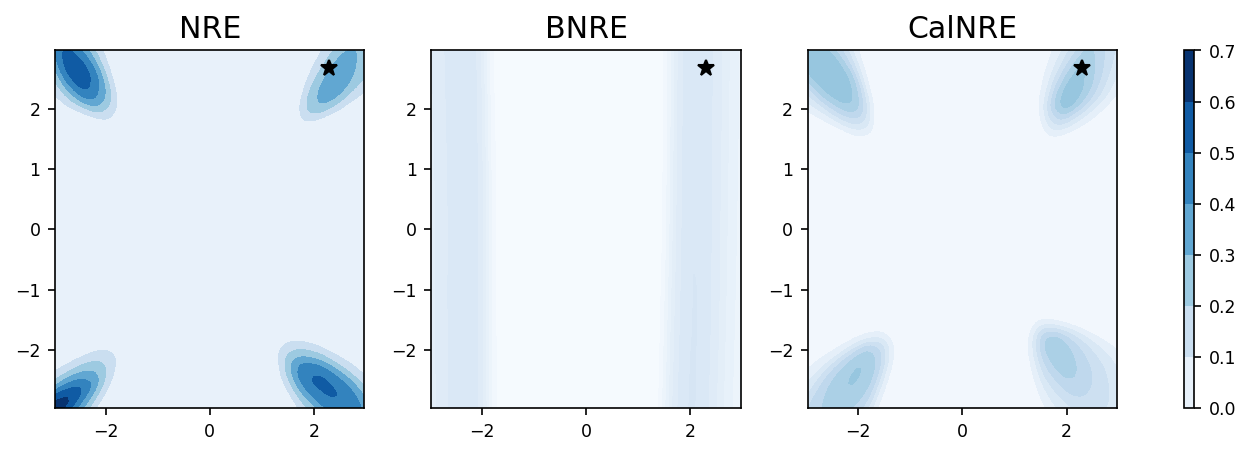

In [9]:
BINS = 100

theta_star = prior.sample()
x_star = slcp(theta_star)

plt.rcParams.update(nice_rc())
fig, axs = plt.subplots(
    ncols=4,
    figsize=(8.5, 3.2),
    gridspec_kw={"width_ratios": [3.2, 3.2, 3.2, 0.1]},
)


# NRE
@torch.no_grad()
def posterior(theta):  # p(\theta | x^*)
    return (nre_estimator(theta, x_star) + prior.log_prob(theta)).exp()


theta, probs = gridapply(posterior, bins=BINS, bounds=(LOWER, UPPER))

vmax = probs.max().item()

cplot = axs[0].contourf(
    theta[..., 0], theta[..., 1], probs, cmap="Blues", vmax=vmax
)
axs[0].plot(theta_star[0], theta_star[1], "*", markersize=8, color="k")
axs[0].set_title("NRE")


# BNRE
@torch.no_grad()
def posterior(theta):  # p(\theta | x^*)
    return (bnre_estimator(theta, x_star) + prior.log_prob(theta)).exp()


theta, probs = gridapply(posterior, bins=BINS, bounds=(LOWER, UPPER))

axs[1].contourf(theta[..., 0], theta[..., 1], probs, cmap="Blues", vmax=vmax)
axs[1].plot(theta_star[0], theta_star[1], "*", markersize=8, color="k")
axs[1].set_title("BNRE")


# CalNRE
@torch.no_grad()
def posterior(theta):  # p(\theta | x^*)
    return (cal_nre_estimator(theta, x_star) + prior.log_prob(theta)).exp()


theta, probs = gridapply(posterior, bins=BINS, bounds=(LOWER, UPPER))

axs[2].contourf(theta[..., 0], theta[..., 1], probs, cmap="Blues", vmax=vmax)
axs[2].plot(theta_star[0], theta_star[1], "*", markersize=8, color="k")
axs[2].set_title("CalNRE")

plt.colorbar(cplot, cax=axs[3])
plt.show()

## Compute expected coverage curves

/home/maciej/venvs/calibrated-posterior/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Coverages evaluated: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:11<00:00, 14.39it/s]


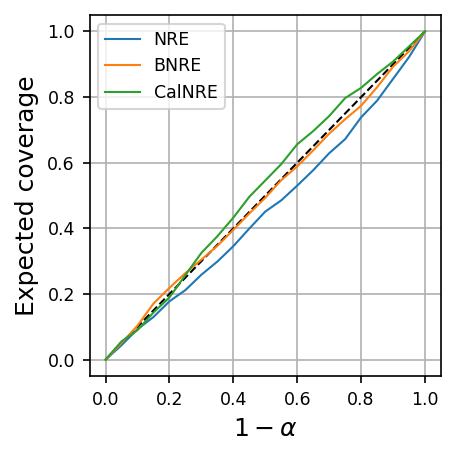

In [10]:
confidence_levels = np.linspace(0.05, 0.95, 19)


@torch.no_grad()
def highest_density_level(density, alpha, min_epsilon=10e-10, region=False):
    # Check if a numpy type has been specified
    if type(density).__module__ != np.__name__:
        density = density.cpu().clone().numpy()
    else:
        density = np.array(density)
    density = density.astype(np.float64)
    # Check the discrete sum of the density (for scaling)
    integrand = density.sum()
    density /= integrand
    # Compute the level such that 1 - alpha has been satisfied.
    optimal_level = density.max()
    epsilon = 10e-00  # Current error
    while epsilon >= min_epsilon:
        optimal_level += 2 * epsilon  # Overshoot solution, move back
        epsilon /= 10
        area = 0.0
        while area < (1 - alpha):
            area_under = density >= optimal_level
            area = np.sum(area_under * density)
            optimal_level -= epsilon  # Gradient descent to reduce error
    optimal_level += epsilon / 2
    # Rescale to original
    optimal_level *= integrand
    # Check if the computed mask needs to be returned
    if region:
        return optimal_level, area_under
    else:
        return optimal_level


resolution = 90
epsilon = 0.00001
p1 = torch.linspace(
    LOWER[0], UPPER[0] - epsilon, resolution
)  # Account for half-open interval of uniform prior
p2 = torch.linspace(
    LOWER[1], UPPER[1] - epsilon, resolution
)  # Account for half-open interval of uniform prior
g1, g2 = torch.meshgrid(p1.view(-1), p2.view(-1))
inputs = torch.cat([g1.reshape(-1, 1), g2.reshape(-1, 1)], dim=1)
log_prior_probabilities = prior.log_prob(inputs).view(-1, 1)


@torch.no_grad()
def estimate_coverage(r, alphas=[0.05], verbose=True):
    n = len(testset)
    covered = [0 for _ in alphas]

    for index, (nominal, observable) in enumerate(
        tqdm(testset, "Coverages evaluated", disable=not verbose)
    ):
        # Prepare setup
        observables = observable.repeat(resolution**2, 1).float()
        log_ratios = r(inputs, observables).unsqueeze(-1)
        pdf = (
            (log_prior_probabilities + log_ratios).view(resolution, resolution)
        ).exp()
        nominal_pdf = (r(nominal, observable) + prior.log_prob(nominal)).exp()
        for i, alpha in enumerate(alphas):
            level, mask = highest_density_level(pdf, alpha, region=True)
            if nominal_pdf >= level:
                covered[i] += 1

    return [x / n for x in covered]


fig = plt.figure(figsize=(3.2, 3.2))

plt.plot([0, 1], [0, 1], "--k")
coverage = estimate_coverage(nre_estimator, confidence_levels)
plt.plot([1, *(1 - confidence_levels), 0], [1, *coverage, 0], label="NRE")
coverage = estimate_coverage(bnre_estimator, confidence_levels)
plt.plot([1, *(1 - confidence_levels), 0], [1, *coverage, 0], label="BNRE")
coverage = estimate_coverage(cal_nre_estimator, confidence_levels)
plt.plot([1, *(1 - confidence_levels), 0], [1, *coverage, 0], label="CalNRE")

plt.grid()
plt.xlabel(r"$1 - \alpha$")
plt.ylabel("Expected coverage")
plt.legend()
plt.show()

# CalNRE HP search

In [11]:
# lmbdas = [5, 10, 20, 40, 80, 100]
# n_sampless = [2, 4, 8, 16, 32, 64]

# con_results = np.ones(
#     (len(lmbdas), len(n_sampless),)
# ) * float("inf")

# cal_results = np.ones(
#     (len(lmbdas), len(n_sampless),)
# ) * float("inf")

# for lmbda_idx, lmbda in enumerate(tqdm(lmbdas, "Lambdas")):
#     for n_samples_idx, n_samples in enumerate(tqdm(n_sampless, "#Samples")):
#         cal_nre_estimator = train_cal_estimator(
#             estimator=deepcopy(estimator),
#             lmbda=lmbda,
#             prior=prior,
#             n_samples=int(n_samples),
#             instances_subsample=1,
#             calibration=0,
#             epochs=500,
#             verbose=False,
#         )
#         with torch.no_grad():
#             coverage = estimate_coverage(cal_nre_estimator, confidence_levels, verbose=False)
#             con_results[
#                 lmbda_idx, n_samples_idx
#             ] = np.maximum((1 - confidence_levels) - coverage, 0).mean()
#             cal_results[
#                 lmbda_idx, n_samples_idx
#             ] = np.absolute((1 - confidence_levels) - coverage).mean()


# fig, axs = plt.subplots(
#     ncols=3,
#     figsize=(6.5, 3.2),
#     gridspec_kw={"width_ratios": [3.2, 3.2, 0.1]},
# )

# axs[0].imshow(
#     con_results,
#     cmap="hot",
#     interpolation="nearest",
#     extent=[n_sampless[0], n_sampless[-1], lmbdas[-1], lmbdas[0]],
#     aspect=(n_sampless[-1] - n_sampless[0]) / (lmbdas[-1] - lmbdas[0]),
# )
# axs[0].set_title("Mean Rectified Error")
# axs[0].set_ylabel("Lambda")
# axs[0].set_xlabel("# Samples")

# cplot = axs[1].imshow(
#     cal_results,
#     cmap="hot",
#     interpolation="nearest",
#     extent=[n_sampless[0], n_sampless[-1], lmbdas[-1], lmbdas[0]],
#     aspect=(n_sampless[-1] - n_sampless[0]) / (lmbdas[-1] - lmbdas[0]),
# )
# axs[1].set_title("Mean Absolute Error")
# axs[1].set_ylabel("Lambda")
# axs[1].set_xlabel("# Samples")

# plt.colorbar(cplot, cax=axs[2])
# fig.savefig(f"demo-HP-out.png")
# plt.close()